# Diabetes prediction: decision threshold tuning

## Notebook set-up

In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import configuration as config
import functions as funcs

# Wait for the gradient boosting notebook to finish execution
while True:
    if os.path.exists(config.GRADIENT_BOOSTING_MODEL):
        break

    else:
        time.sleep(5)

## 1. Data preparation

### 1.1. Load data from disk

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
254,12,92.0,62.0,7.000000,258.000000,27.6,0.926,44,1
323,13,152.0,90.0,33.000000,29.000000,26.8,0.731,43,1
447,0,95.0,80.0,45.000000,92.000000,36.5,0.330,26,0
499,6,154.0,74.0,32.000000,193.000000,29.3,0.839,39,0
226,0,101.0,76.0,40.539577,113.252114,35.7,0.198,26,0


## 2. Model comparisons

### 2.1. Cross-validation accuracy

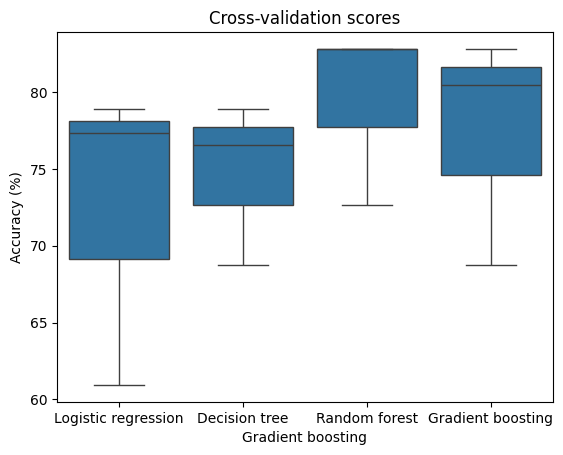

In [4]:
models = {}

models['Logistic regression'] = LogisticRegression(
    max_iter=5000,                     # Increase iterations to ensure convergence
    class_weight=config.CLASS_WEIGHT,  # Handle class imbalance
    random_state=config.RANDOM_SEED    # Ensure reproducible results
).fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree'] = pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest'] = pickle.load(input_file)

with open(config.GRADIENT_BOOSTING_MODEL, 'rb') as input_file:
    models['Gradient boosting'] = pickle.load(input_file)

cross_val_scores = {
    'Model': [],
    'Score': []
}

for model_name, model in models.items():

    scores = cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=config.CROSS_VAL_FOLDS,
        n_jobs=-1
    )

    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(np.array(scores)*100)

plt.title(f'Cross-validation scores')
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.xlabel(model_name)
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

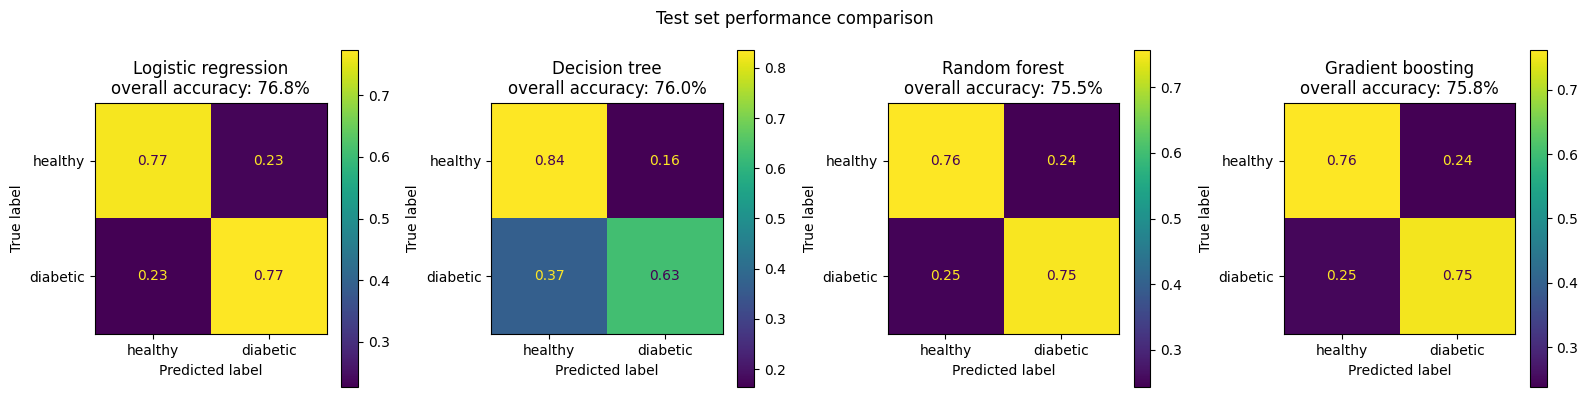

In [5]:
funcs.plot_confusion_matrices(models=models, testing_df=testing_df)

## 3. Call threshold

In [6]:
class_probabilities = models['Logistic regression'].predict_proba(testing_df.drop('Outcome', axis=1))

testing_probabilities_df = pd.DataFrame({
    'Diabetes probability': class_probabilities[:,1],
    'Label': testing_df['Outcome']
})

testing_probabilities_df['Outcome'] = testing_probabilities_df['Label'].map({0: 'No diabetes', 1: 'Diabetes'})

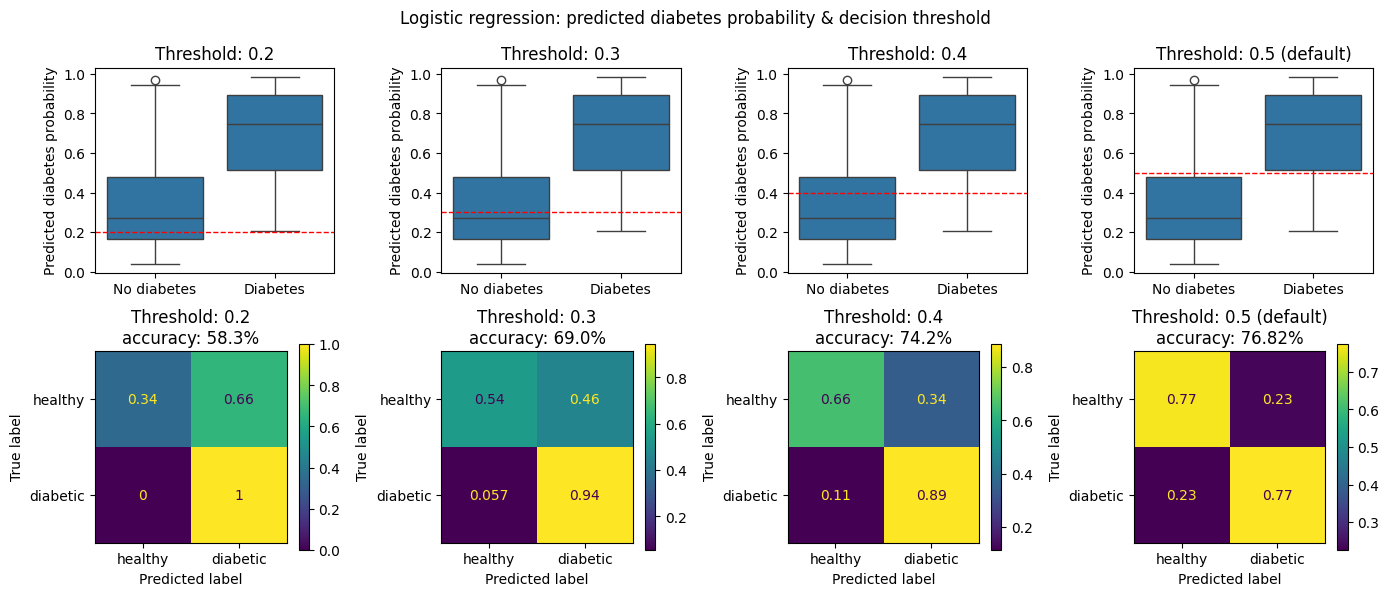

In [7]:
call_thresholds = [0.20, 0.30, 0.40, 0.5]

fig, axs = plt.subplots(2,4, figsize=(14,6))

fig.suptitle(f'Logistic regression: predicted diabetes probability & decision threshold')

for i, threshold in enumerate(call_thresholds):

    # Plot the boxplot
    sns.boxplot(testing_probabilities_df, x='Outcome', y='Diabetes probability', ax=axs[0,i])
    axs[0,i].axhline(threshold, color='red', linestyle='dashed', linewidth=1)

    if threshold == 0.5:
        axs[0,i].set_title(f'Threshold: {threshold} (default)')
    else:
        axs[0,i].set_title(f'Threshold: {threshold}')

    axs[0,i].set_xlabel('')
    axs[0,i].set_ylabel('Predicted diabetes probability')

    # Plot the confusion matrix
    calls = [1 if p > threshold else 0 for p in class_probabilities[:,1]]
    accuracy = accuracy_score(calls, testing_df['Outcome'])*100

    cm = confusion_matrix(testing_df['Outcome'], calls, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy','diabetic'])

    if threshold == 0.5:
        axs[1,i].set_title(f'Threshold: {threshold} (default)\naccuracy: {accuracy:.2f}%')
    else:
        axs[1,i].set_title(f'Threshold: {threshold}\naccuracy: {accuracy:.1f}%')

    _ = cm_disp.plot(ax=axs[1,i])

fig.tight_layout()

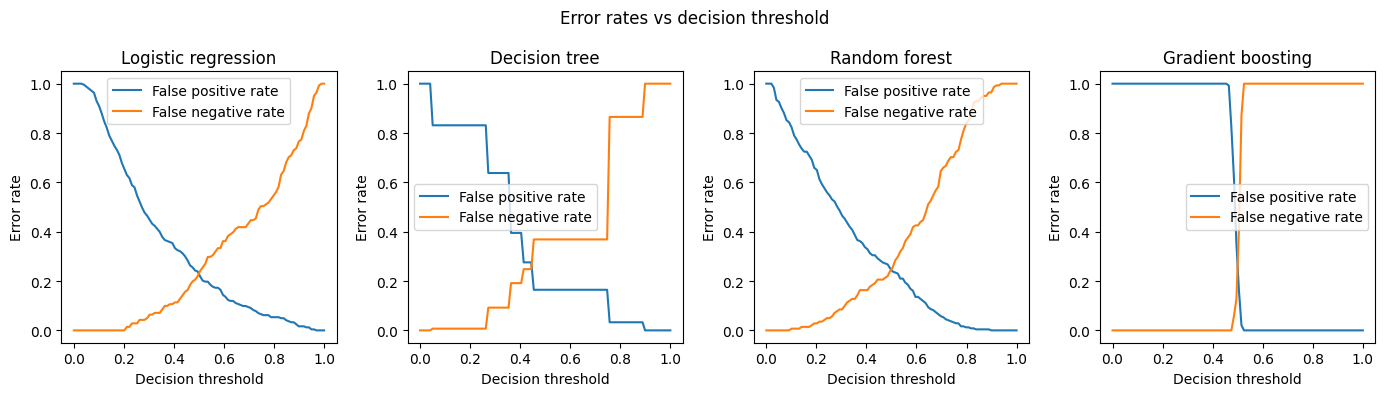

In [8]:
fig, axs = plt.subplots(1,4, figsize=(14,4))
axs = axs.flatten()

fig.suptitle(f'Error rates vs decision threshold')

for i, (model_name, model) in enumerate(models.items()):

    error_rates = {
        'Threshold': [],
        'False positive rate': [],
        'False negative rate': []
    }

    call_thresholds = np.linspace(0, 1, 100)

    class_probabilities = model.predict_proba(testing_df.drop('Outcome', axis=1))

    for j, threshold in enumerate(call_thresholds):
        calls = [1 if p > threshold else 0 for p in class_probabilities[:,1]]
        cm = confusion_matrix(testing_df['Outcome'], calls)

        # Extract TP, TN, FP, FN
        tn, fp, fn, tp = cm.ravel()

        error_rates['False positive rate'].append(fp / (fp + tn))
        error_rates['False negative rate'].append(fn / (fn + tp))
        error_rates['Threshold'].append(threshold)

    axs[i].set_title(f'{model_name}')
    axs[i].plot(error_rates['Threshold'], error_rates['False positive rate'], label='False positive rate')
    axs[i].plot(error_rates['Threshold'], error_rates['False negative rate'], label='False negative rate')
    axs[i].set_xlabel('Decision threshold')
    axs[i].set_ylabel('Error rate')
    axs[i].legend(loc='best')

fig.tight_layout()

## 4. Threshold tuning

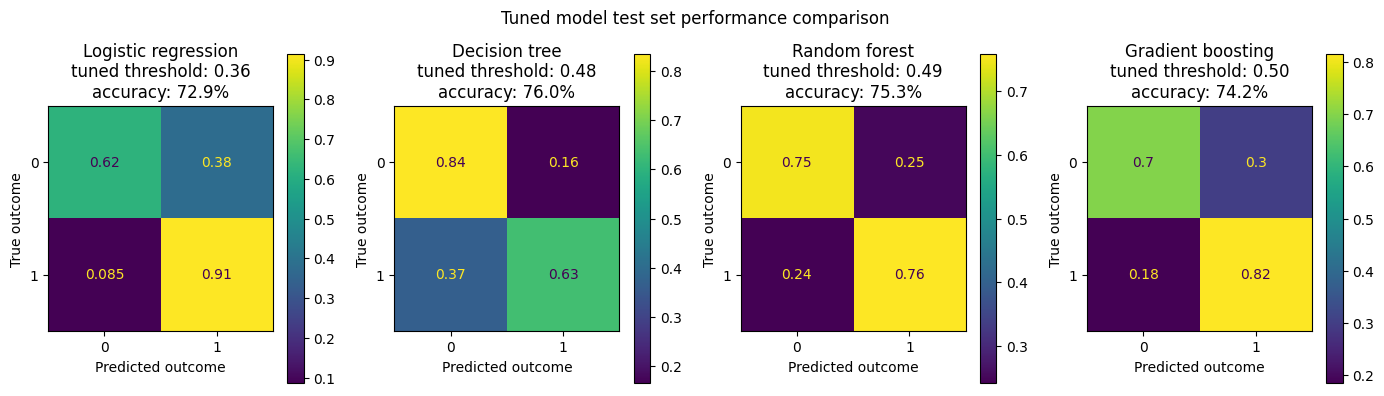

In [9]:
fig, axs = plt.subplots(1,4, figsize=(14,4))
axs = axs.flatten()

fig.suptitle(f'Tuned model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    tuned_model = TunedThresholdClassifierCV(
        model,
        scoring='balanced_accuracy',
        cv=config.CROSS_VAL_FOLDS,
        n_jobs=-1,
        random_state=config.RANDOM_SEED
    )

    tuned_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
    models[model_name] = tuned_model

    testing_predictions = tuned_model.predict(testing_df.drop('Outcome', axis=1))
    accuracy = accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    _ = cm_disp.plot(ax=axs[i])

    axs[i].set_title(f'{model_name}\ntuned threshold: {tuned_model.best_threshold_:.2f}\naccuracy: {accuracy:.1f}%')
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()